<a href="https://colab.research.google.com/github/sujaibanerji/anubhuti1/blob/master/colab.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [29]:
import itertools
from pathlib import Path
from pprint import pprint

from matplotlib import pyplot as plt, cm
import numpy as np
import pandas as pd
from pandas_path import path
from sklearn.dummy import DummyClassifier
from sklearn.preprocessing import minmax_scale
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import make_scorer, log_loss
from sklearn.model_selection import StratifiedKFold, cross_val_score
from tqdm import tqdm

pd.set_option('max_colwidth', 80)
RANDOM_SEED = 42  # For reproducibility

In [5]:
from google.colab import files
uploaded = files.upload()

Saving metadata.csv to metadata.csv


In [6]:
metadata = pd.read_csv('metadata.csv', index_col = 'sample_id')
metadata.head()

,sample_id,split,instrument_type,features_path,features_md5_hash
0,S0000,train,commercial,train_features/S0000.csv,017b9a71a702e81a828e6242aa15f049
1,S0001,train,commercial,train_features/S0001.csv,0d09840214054d254bd49436c6a6f315
2,S0002,train,commercial,train_features/S0002.csv,3f58b3c9b001bfed6ed4e4f757083e09
3,S0003,train,commercial,train_features/S0003.csv,e9a12f96114a2fda60b36f4c0f513fb1
4,S0004,train,commercial,train_features/S0004.csv,b67603d3931897bfa796ac42cc16de78


In [7]:
train_files = metadata[metadata["split"] == "train"]["features_path"].to_dict()
val_files = metadata[metadata["split"] == "val"]["features_path"].to_dict()
test_files = metadata[metadata["split"] == "test"]["features_path"].to_dict()

print('Number of training samples: ', len(train_files))
print('Number of validation samples: ', len(val_files))
print('Number of testing samples: ', len(test_files))

Number of training samples:  766
Number of validation samples:  293
Number of testing samples:  511


[Text(0, 0, '64'), Text(0, 0, '12'), Text(0, 0, '0')]

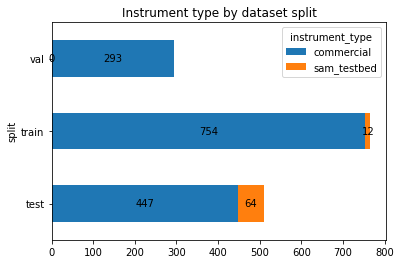

In [8]:
# Share of samples from commercial instruments vs. SAM testbed
meta_instrument = (
    metadata.reset_index()
    .groupby(['split', 'instrument_type'])['sample_id']
    .aggregate('count')
    .reset_index()
)
meta_instrument = meta_instrument.pivot(
    index = 'split', columns = 'instrument_type', values = 'sample_id'
).reset_index()
meta_instrument.head()

ax = meta_instrument.plot(
    x = 'split',
    kind = 'barh',
    stacked = True,
    title = 'Instrument type by dataset split',
    mark_right = True,
)
ax.bar_label(ax.containers[0], label_type="center")
ax.bar_label(ax.containers[1], label_type="center")

In [12]:
from google.colab import files
uploaded = files.upload()

Saving S0000.csv to S0000.csv
Saving S0001.csv to S0001.csv
Saving S0002.csv to S0002.csv
Saving S0003.csv to S0003.csv
Saving S0004.csv to S0004.csv
Saving S0005.csv to S0005.csv
Saving S0006.csv to S0006.csv
Saving S0007.csv to S0007.csv
Saving S0008.csv to S0008.csv
Saving S0009.csv to S0009.csv
Saving S0010.csv to S0010.csv
Saving S0011.csv to S0011.csv
Saving S0012.csv to S0012.csv
Saving S0013.csv to S0013.csv
Saving S0014.csv to S0014.csv
Saving S0015.csv to S0015.csv
Saving S0016.csv to S0016.csv
Saving S0017.csv to S0017.csv
Saving S0018.csv to S0018.csv
Saving S0019.csv to S0019.csv
Saving S0020.csv to S0020.csv
Saving S0021.csv to S0021.csv
Saving S0022.csv to S0022.csv
Saving S0023.csv to S0023.csv
Saving S0024.csv to S0024.csv
Saving S0025.csv to S0025.csv
Saving S0026.csv to S0026.csv
Saving S0027.csv to S0027.csv
Saving S0028.csv to S0028.csv
Saving S0029.csv to S0029.csv
Saving S0030.csv to S0030.csv
Saving S0031.csv to S0031.csv
Saving S0032.csv to S0032.csv
Saving S00

In [18]:
from google.colab import files
uploaded = files.upload()

Saving train_labels.csv to train_labels.csv


In [27]:
train_labels = pd.read_csv('train_labels.csv', index_col = 'sample_id')
train_labels.head()

,basalt,carbonate,chloride,iron_oxide,oxalate,oxychlorine,phyllosilicate,silicate,sulfate,sulfide
sample_id,,,,,,,,,,
S0000,0,0,0,0,0,0,0,0,1,0
S0001,0,1,0,0,0,0,0,0,0,0
S0002,0,0,0,0,0,1,0,0,0,0
S0003,0,1,0,1,0,0,0,0,1,0
S0004,0,0,0,1,0,1,1,0,0,0


Text(0.5, 1.0, 'Compounds represented in training set')

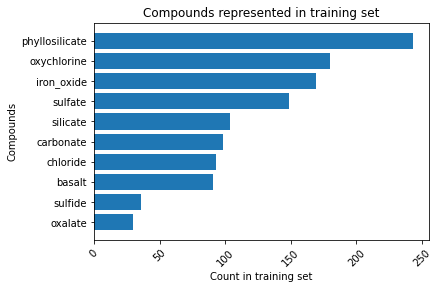

In [28]:
sumlabs = train_labels.aggregate('sum').sort_values()
plt.barh(sumlabs.index, sumlabs, align="center")
plt.ylabel("Compounds")
plt.xticks(rotation=45)
plt.xlabel("Count in training set")
plt.title("Compounds represented in training set")

In [30]:
# Select sample IDs for five commercial samples and five testbed samples
sample_id_commercial = (
    metadata[metadata['instrument_type'] == 'commercial']
    .index
    .values[0:5]
)
sample_id_testbed = (
    metadata[metadata['instrument_type'] == 'sam_testbed']
    .index
    .values[0:5]
)

In [37]:
# Import sample files for EDA
sample_commercial_dict = {}
sample_testbed_dict = {}

for i in range(0, 5):
    comm_lab = sample_id_commercial[i]
    sample_commercial_dict[comm_lab] = pd.read_csv(train_files[comm_lab])

    test_lab = sample_id_testbed[i]
    sample_testbed_dict[test_lab] = pd.read_csv(r'/content/*.csv')

FileNotFoundError: ignored